# 封装maskrcnn

In [151]:
import cv2
import numpy as np
import os.path
import sys
import random
from matplotlib import pyplot as plt

# Load names of classes
classesFile = "model/mask_rcnn_inception_v2_coco_2018_01_28/mscoco_labels.names";
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# Load the classes
colorsFile = "model/mask_rcnn_inception_v2_coco_2018_01_28/colors.txt";
with open(colorsFile, 'rt') as f:
    colorsStr = f.read().rstrip('\n').split('\n')
    
colors = [] #[0,0,0]
for i in range(len(colorsStr)):
    rgb = colorsStr[i].split(' ')
    color = np.array([float(rgb[0]), float(rgb[1]), float(rgb[2])])
    colors.append(color)   

#   Draw the predicted bounding box, colorize and show the mask on the image
def drawBox(frame, left, top, right, bottom, classMask,maskThreshold = 0.2):
    # Resize the mask
    classMask = cv2.resize(classMask, (right - left + 1, bottom - top + 1))
    mask = (classMask > maskThreshold)
    roi = frame[top:bottom+1, left:right+1][mask]
    
    colorIndex = random.randint(0, len(colors)-1)
    color = colors[colorIndex]
    
    frame[top:bottom+1, left:right+1][mask] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.7 * roi).astype(np.uint8)
   
    return frame
 

# For each frame, extract the bounding box and mask for each detected object
def postprocess(frame,boxes, masks,confThreshold = 0.2):
    numClasses = masks.shape[1]
    numDetections = boxes.shape[2]
    
    frameH = frame.shape[0]
    frameW = frame.shape[1]
    
    mask_image=np.zeros(frame.shape, np.uint8)
    labels=[]
    
    for i in range(numDetections):
        box = boxes[0, 0, i]
        mask = masks[i]
        score = box[2]
        #print(score)
        if score > confThreshold:
            classId = int(box[1])
            # Extract the bounding box
            left = int(frameW * box[3])
            top = int(frameH * box[4])
            right = int(frameW * box[5])
            bottom = int(frameH * box[6])
            
            left = max(0, min(left, frameW - 1))
            top = max(0, min(top, frameH - 1))
            right = max(0, min(right, frameW - 1))
            bottom = max(0, min(bottom, frameH - 1))
            
            # Extract the mask for the object
            classMask = mask[classId]
            
            label = classes[classId]
            #print(label,score)
            labels.append([label,score])
            # Draw bounding box, colorize and show the mask on the image
            mask_image=drawBox(mask_image, left, top, right, bottom, classMask)
    return labels,mask_image

# Give the textGraph and weight files for the model
textGraph = "model/mask_rcnn_inception_v2_coco_2018_01_28/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt";
modelWeights = "model/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb";

# Load the network
model = cv2.dnn.readNetFromTensorflow(modelWeights, textGraph);
model.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
model.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

def predict(img_input):
    img_input=img_input.copy()
    # Create a 4D blob from a frame.
    blob = cv2.dnn.blobFromImage(img_input, swapRB=True, crop=False)
    #print(blob)
    # Set the input to the network
    model.setInput(blob)
    # Run the forward pass to get output from the output layers
    boxes, masks = model.forward(['detection_out_final', 'detection_masks'])

    # Extract the bounding box and mask for each of the detected objects
    labels,mask_image=postprocess(img_input,boxes, masks)
    
    return labels,mask_image


# 绘制汉字 ，等比例缩放

In [75]:
#绘制汉字
from PIL import Image, ImageDraw, ImageFont

def draw_text(text="时尚杂志封面",font_size=80):
    font = ImageFont.truetype("/System/Library/Fonts/Supplemental/Songti.ttc",font_size, encoding="utf-8") # 参数1：字体文件路径，参数2：字体大小
    w,h=font.getsize(text)
    #改造下，取要叠加文字的背景
    text_image = Image.fromarray(np.zeros((h,w,3), np.uint8))
    draw = ImageDraw.Draw(text_image)
    draw.text((0, 0), text, (255, 0, 0), font=font) 
    text_image=cv2.cvtColor(np.array(text_image), cv2.COLOR_RGB2BGR)
    return text_image

#等比例缩放
def img_resize(image,w,h):
    height, width = image.shape[0], image.shape[1]
    # 判断图片的长宽比率
    if width / height >= w / h:
        img_new = cv2.resize(image, (w, int(height * w / width)),interpolation = cv2.INTER_AREA)
    else:
        img_new = cv2.resize(image, (int(width * h / height), h),interpolation = cv2.INTER_AREA)
    return img_new


# def add_text(img,text,x,y,w,h):
#     img=img.copy()
#     text_image=draw_text(text,h)
#     text_image=img_resize(text_image,w,h)
#     #print(w/h,text_image.shape)
#     h,w,_=text_image.shape
#     bg=img[y:y+h,x:x+w].copy()
#     for i in range(text_image.shape[0]):
#         for j in range(text_image.shape[1]):
#             if np.sum(text_image[i,j])==0:
#                 text_image[i,j]=bg[i,j]
#     img[y:y+h,x:x+w]=text_image
#     return img

(100, 100, 3)


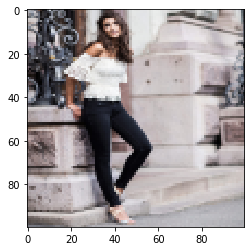

[['person', 0.9659693]]


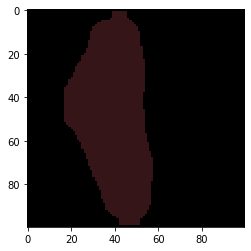

In [152]:
# 测试
image = cv2.imread('img/Maryam-Razavi_pitsitoppi590.jpg')  

img_input=cv2.resize(image, (100,100), interpolation = cv2.INTER_AREA)
print(img_input.shape)

plt.imshow(cv2.cvtColor(img_input,cv2.COLOR_BGR2RGB))
plt.show()

labels,mask_image=predict(img_input)
print(labels)
plt.imshow(cv2.cvtColor(mask_image,cv2.COLOR_BGR2RGB))
plt.show()

# 测试下 绘制 文字

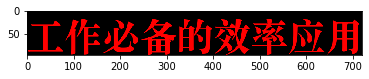

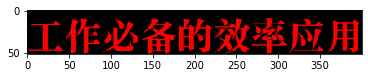

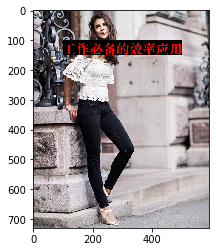

In [40]:
#print(mask_image.shape)

#人物mask
mask_image=cv2.resize(mask_image, (image.shape[1],image.shape[0]), interpolation = cv2.INTER_AREA)

#文字
text_image=draw_text("工作必备的效率应用",80)

plt.imshow(cv2.cvtColor(text_image,cv2.COLOR_BGR2RGB))
plt.show()

x=100
y=100
w=400
h=80

text_image=img_resize(text_image,w,h)
plt.imshow(cv2.cvtColor(text_image,cv2.COLOR_BGR2RGB))
plt.show()

#绘制文字至背景上
bg_image=image.copy()
bg_image[y:y+text_image.shape[0],x:x+text_image.shape[1]]=text_image

plt.imshow(cv2.cvtColor(bg_image,cv2.COLOR_BGR2RGB))
plt.show()


# 进一步改进

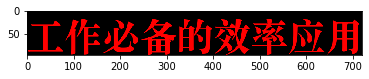

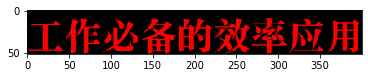

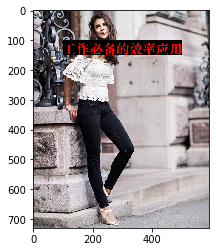

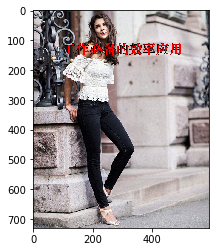

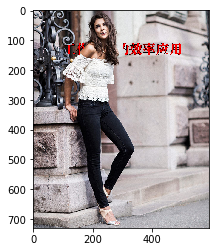

In [21]:
#print(mask_image.shape)

#人物mask
mask_image=cv2.resize(mask_image, (image.shape[1],image.shape[0]), interpolation = cv2.INTER_AREA)

#文字
text_image=draw_text("工作必备的效率应用",80)

plt.imshow(cv2.cvtColor(text_image,cv2.COLOR_BGR2RGB))
plt.show()

x=100
y=100
w=400
h=80

text_image=img_resize(text_image,w,h)
plt.imshow(cv2.cvtColor(text_image,cv2.COLOR_BGR2RGB))
plt.show()

#绘制文字至背景上-->改造下
th,tw,_=text_image.shape

bg_image=image.copy()
bg_image[y:y+th,x:x+tw]=text_image

plt.imshow(cv2.cvtColor(bg_image,cv2.COLOR_BGR2RGB))
plt.show()


#去除字体的黑底
for i in range(y,y+th):
    for j in range(x,x+tw):
        
        if np.sum(bg_image[i][j])==0:
            bg_image[i][j]=image[i][j]
plt.imshow(cv2.cvtColor(bg_image,cv2.COLOR_BGR2RGB))
plt.show()

#去除人物mask
for i in range(y,y+th):
    for j in range(x,x+tw):
        #去除人物mask
        if np.sum(mask_image[i][j])>0:
            bg_image[i][j]=image[i][j]
            
plt.imshow(cv2.cvtColor(bg_image,cv2.COLOR_BGR2RGB))
plt.show()

#

# 封装成函数

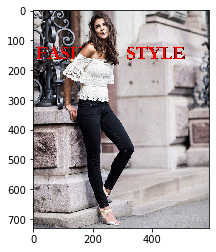

In [153]:
def design(image,text="工作必备的效率应用",x=10,y=100):
    img_input=cv2.resize(image, (400,400), interpolation = cv2.INTER_AREA)
    labels,mask_image=predict(img_input)
    mask_image=cv2.resize(mask_image, (image.shape[1],image.shape[0]), interpolation = cv2.INTER_AREA)

    #文字
    text_image=draw_text(text,260)

    w=500
    h=260

    text_image=img_resize(text_image,w,h)

    #绘制文字至背景上-->改造下
    th,tw,_=text_image.shape
    bg_image=image.copy()
    
    #保证2者相同shape
    th,tw,_=bg_image[y:y+th,x:x+tw].shape
    #print(th,tw,text_image.shape)
    bg_image[y:y+th,x:x+tw]=cv2.resize(text_image,(tw,th))
#     plt.imshow(cv2.cvtColor(bg_image[y:y+th,x:x+tw],cv2.COLOR_BGR2RGB))
#     plt.show()
    for i in range(y,y+th):
        for j in range(x,x+tw):
            #去除字体的黑底
            if np.sum(bg_image[i][j])==0:
                bg_image[i][j]=image[i][j]
            #去除人物mask
            if np.sum(mask_image[i][j])>0:
                bg_image[i][j]=image[i][j]

    return bg_image

#测试
image = cv2.imread('img/Maryam-Razavi_pitsitoppi590.jpg')  
bg_image=design(image,"FASHION STYLE")
plt.imshow(cv2.cvtColor(bg_image,cv2.COLOR_BGR2RGB))
plt.show()

#

# 视频

In [23]:
import time
t1=time.time()
# 视频加载 
videoCapture=cv2.VideoCapture('video/402520988.mp4')
    
#step2:get a frame
success,frame=videoCapture.read()

# 获取视频fps
fps = videoCapture.get(cv2.CAP_PROP_FPS)
# 获取视频总帧数
frame_all = videoCapture.get(cv2.CAP_PROP_FRAME_COUNT)
print("[INFO] 视频FPS: {}".format(fps))
print("[INFO] 视频总帧数: {}".format(frame_all))
print("[INFO] 视频时长: {}s".format(frame_all/fps))

#step3:get frames in a loop and do process 
frames=[]
while(success):
    videoCapture.set(cv2.CAP_PROP_POS_FRAMES,fps*len(frames)*10)
    success,frame=videoCapture.read()
    if success:
        frames.append(frame)

print(time.time()-t1,len(frames))

[INFO] 视频FPS: 25.0
[INFO] 视频总帧数: 3855.0
[INFO] 视频时长: 154.2s
0.3897271156311035 16


In [6]:
t1=time.time()
main_frames_index=[]
for index,frame in enumerate(frames):
    face_detect = cv2.CascadeClassifier('model/haarcascades/haarcascade_frontalface_default.xml')
    face_zone = face_detect.detectMultiScale(frame, scaleFactor=1.1, minNeighbors=5)
    #print ('识别人脸的信息：',face_zone)
    if len(face_zone)>0:
        img_input=cv2.resize(frame, (300,300), interpolation = cv2.INTER_AREA)
        labels,mask_image=predict(img_input)
        if len(labels)>0:
            main_frames_index.append(index)
#             print(labels,index)
#             plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
#             plt.show()
print(time.time()-t1)

6.847771167755127


In [7]:
main_frames_index

[6, 8, 9, 10, 11]

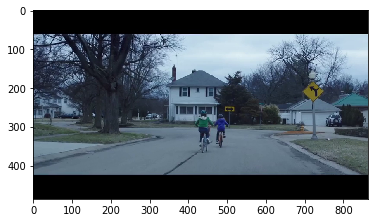

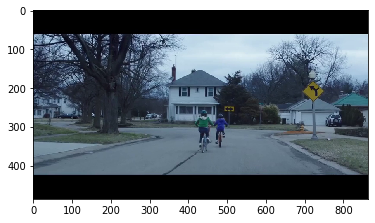

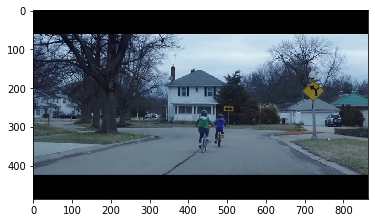

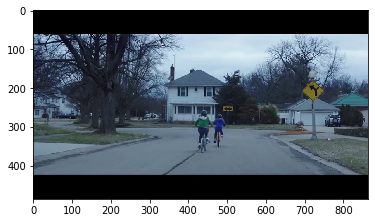

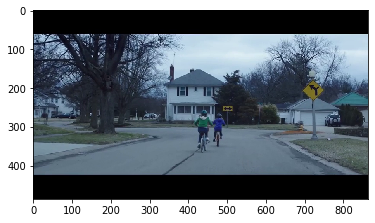

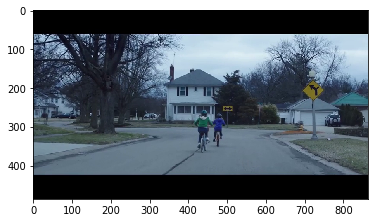

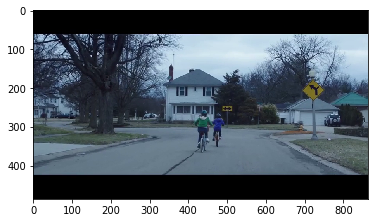

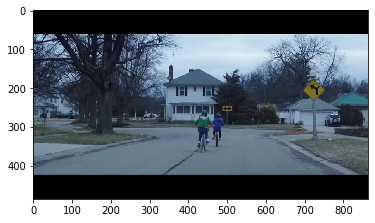

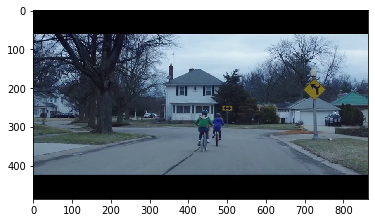

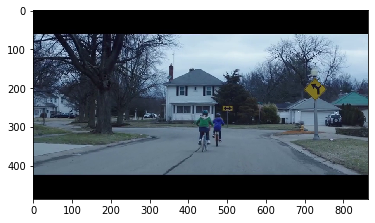

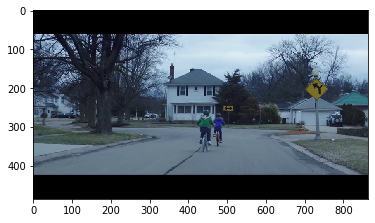

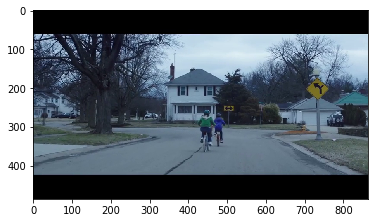

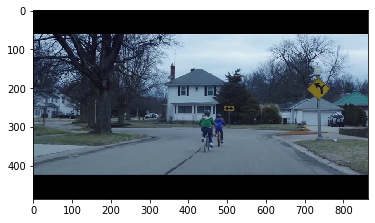

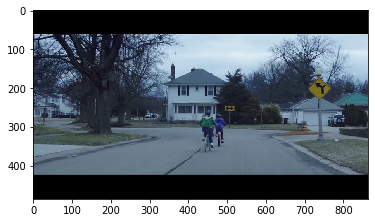

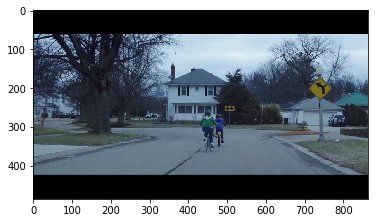

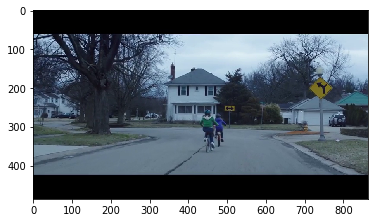

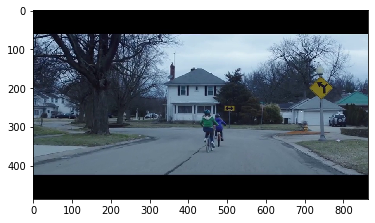

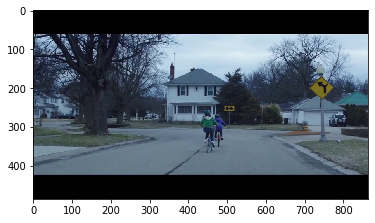

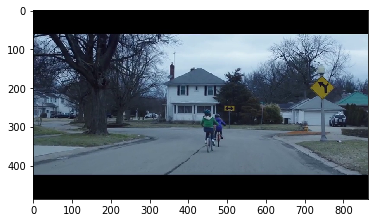

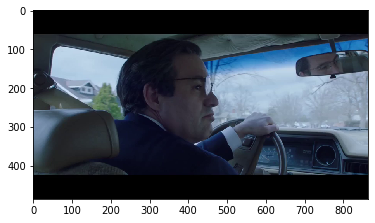

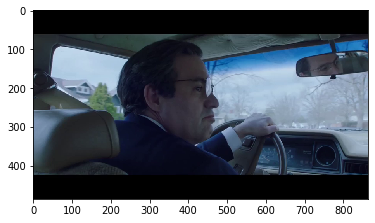

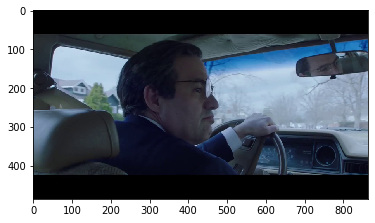

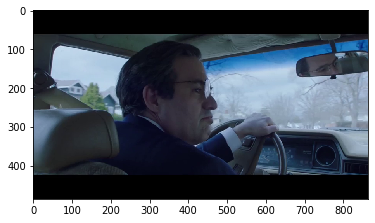

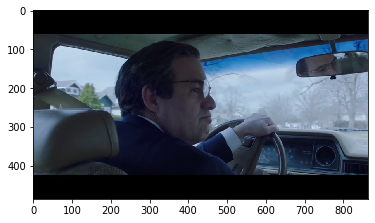

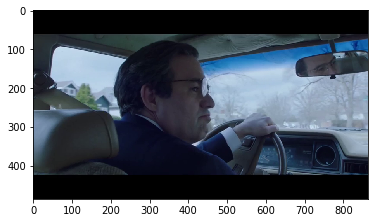

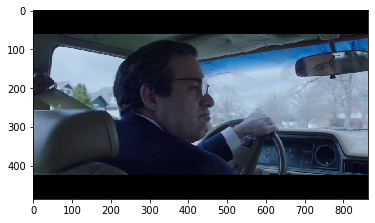

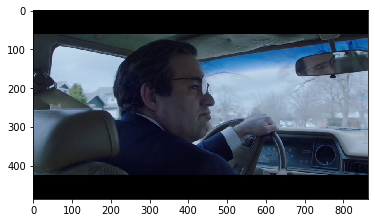

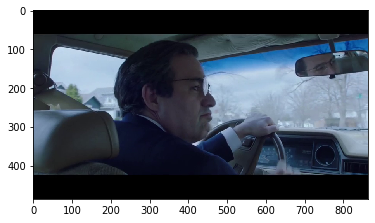

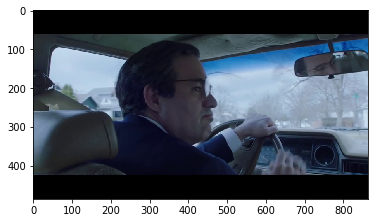

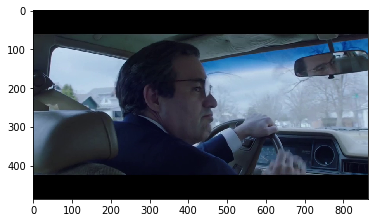

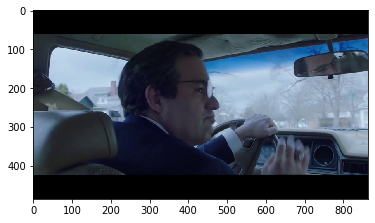

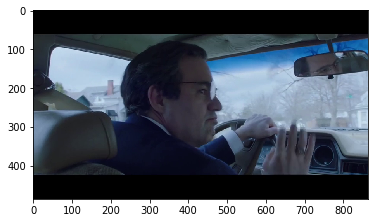

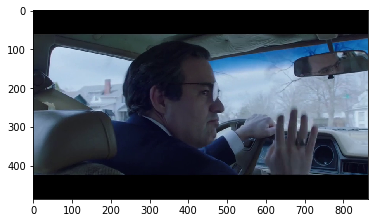

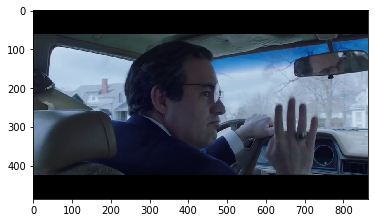

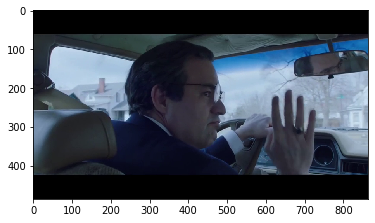

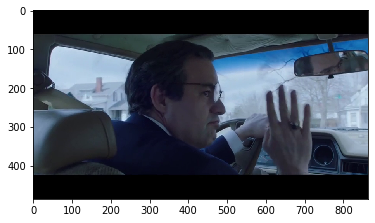

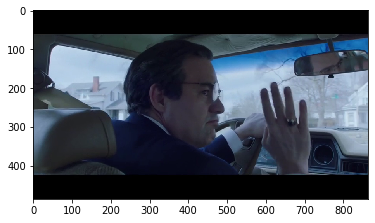

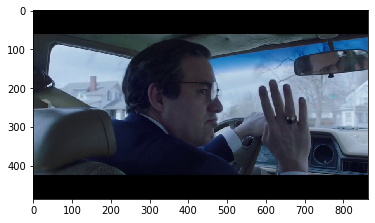

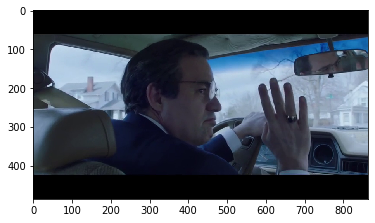

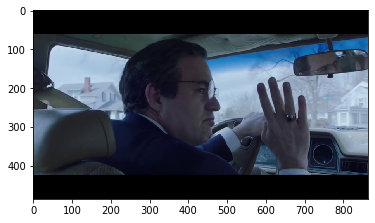

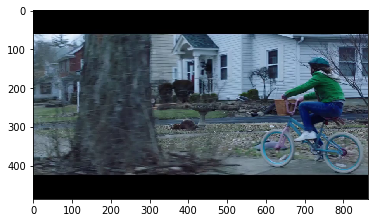

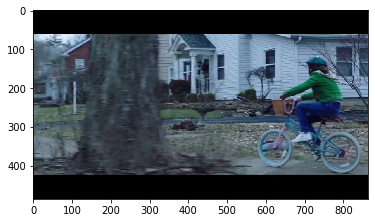

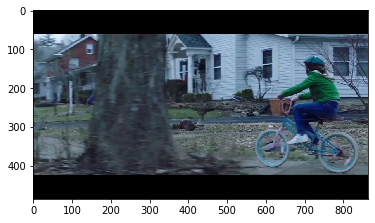

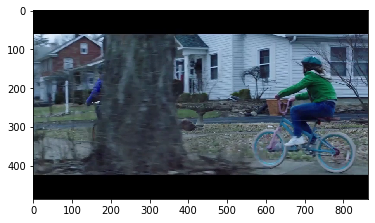

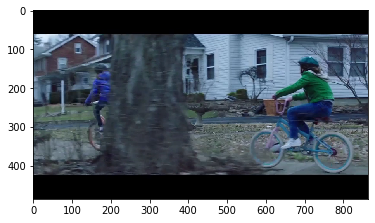

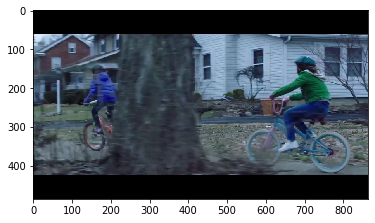

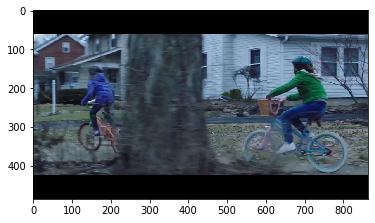

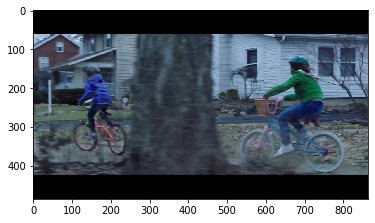

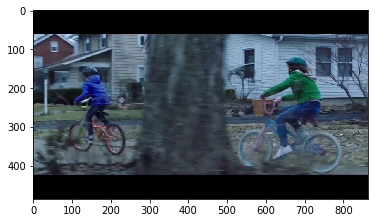

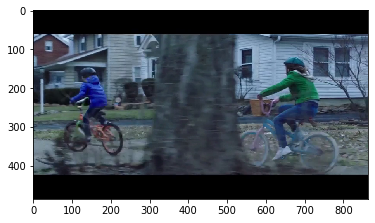

In [8]:
for i in range(int(fps*main_frames_index[1]-fps),int(fps*main_frames_index[1]+fps)):
    videoCapture.set(cv2.CAP_PROP_POS_FRAMES,i)
    success,frame=videoCapture.read()
    if success:
        plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
        plt.show()

In [33]:
success

True

In [ ]:
videoCapture.release()

# 场景检测

In [9]:
import scenedetect
from scenedetect.video_manager import VideoManager
from scenedetect.scene_manager import SceneManager
from scenedetect.frame_timecode import FrameTimecode
from scenedetect.stats_manager import StatsManager
from scenedetect.detectors import ContentDetector

STATS_FILE_PATH = 'video/testvideo.stats.csv'

In [10]:
video_manager = VideoManager(['video/402520988.mp4'])
stats_manager = StatsManager()
scene_manager = SceneManager(stats_manager)

# Add ContentDetector algorithm (constructor takes detector options like threshold).
scene_manager.add_detector(ContentDetector())
base_timecode = video_manager.get_base_timecode()

if os.path.exists(STATS_FILE_PATH):
    # Read stats from CSV file opened in read mode:
    with open(STATS_FILE_PATH, 'r') as stats_file:
        stats_manager.load_from_csv(stats_file, base_timecode)

start_time = base_timecode + 20     # 00:00:00.667
end_time = base_timecode + 20.0     # 00:00:20.000
# Set video_manager duration to read frames from 00:00:00 to 00:00:20.
video_manager.set_duration(start_time=start_time, end_time=end_time)

# Set downscale factor to improve processing speed (no args means default).
video_manager.set_downscale_factor()

# Start video_manager.
video_manager.start()

# Perform scene detection on video_manager.
scene_manager.detect_scenes(frame_source=video_manager)

# Obtain list of detected scenes.
scene_list = scene_manager.get_scene_list(base_timecode)

# We only write to the stats file if a save is required:
if stats_manager.is_save_required():
    with open(STATS_FILE_PATH, 'w') as stats_file:
        stats_manager.save_to_csv(stats_file, base_timecode)


video_manager.release()

100%|██████████| 481/481 [00:00<00:00, 2962.44frames/s]


List of scenes obtained:


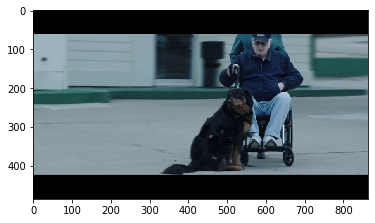

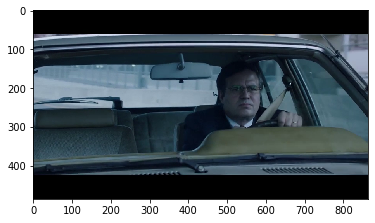

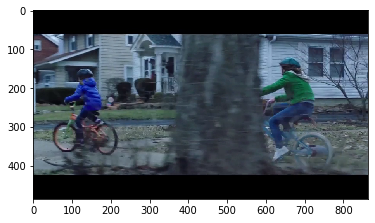

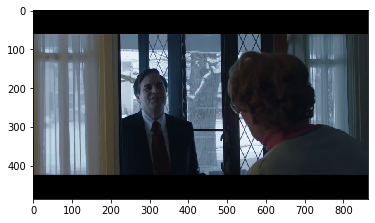

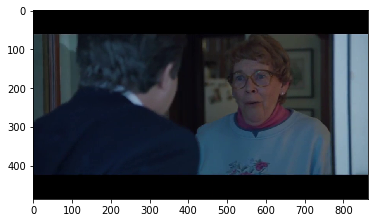

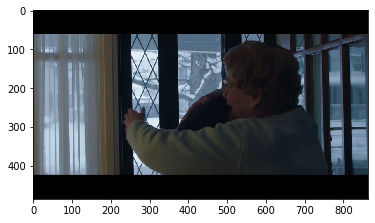

In [44]:
# 视频加载 
videoCapture=cv2.VideoCapture('video/402520988.mp4')
face_detect = cv2.CascadeClassifier('model/haarcascades/haarcascade_frontalface_default.xml')

main_scenes=[]
print('List of scenes obtained:')
for i, scene in enumerate(scene_list):
    index=int((scene[0].get_frames()+scene[1].get_frames())/2)
    videoCapture.set(cv2.CAP_PROP_POS_FRAMES,index)
    success,frame=videoCapture.read()
    if success:
        face_zone = face_detect.detectMultiScale(frame, scaleFactor=1.1, minNeighbors=5)
        #print ('识别人脸的信息：',face_zone)
        if len(face_zone)>0:
            img_input=cv2.resize(frame, (300,300), interpolation = cv2.INTER_AREA)
            labels,mask_image=predict(img_input)
            if len(labels)>0:
                plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
                plt.show()
                main_scenes.append([scene[0].get_frames(),scene[1].get_frames()])

In [12]:
main_scenes_frames=[]
for scene in main_scenes:
    print(scene)
    frames=[]
    for i in range(scene[0],scene[1]):
        videoCapture.set(cv2.CAP_PROP_POS_FRAMES,i)
        success,frame=videoCapture.read()
        if success:
            frames.append(frame)
    main_scenes_frames.append(frames)

[116, 146]
[146, 170]
[215, 237]
[260, 293]
[293, 333]
[333, 396]


In [13]:
videoCapture.release()

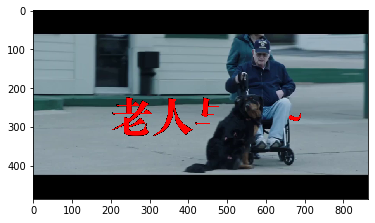

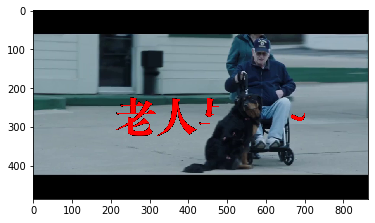

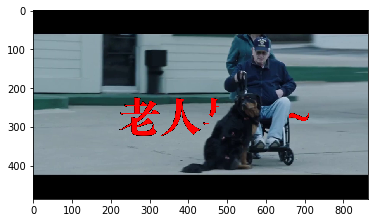

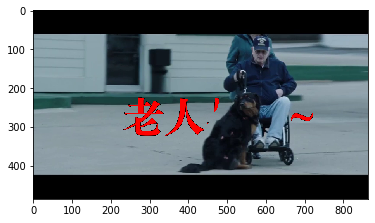

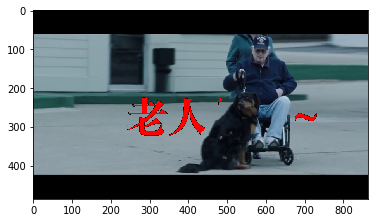

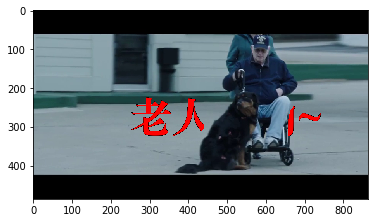

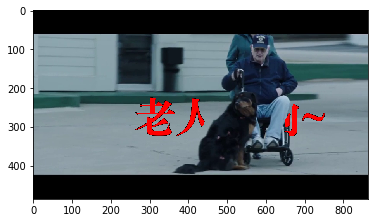

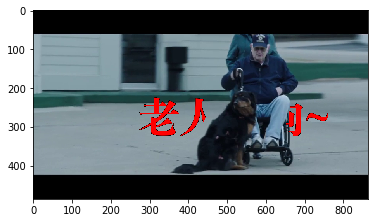

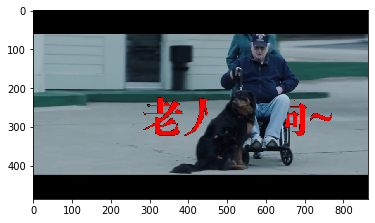

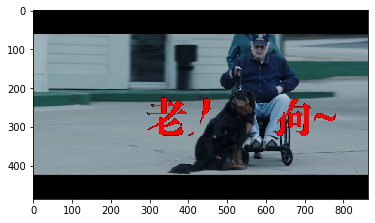

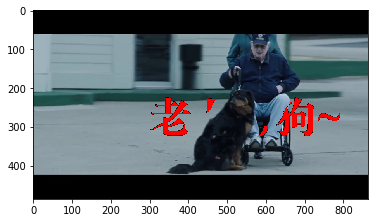

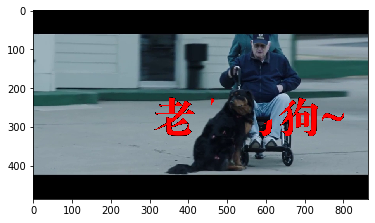

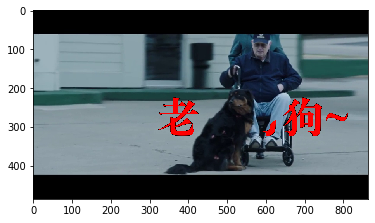

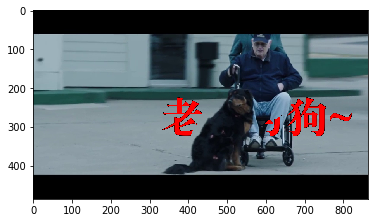

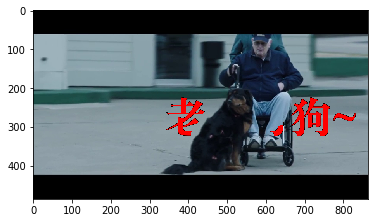

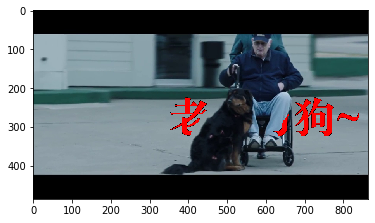

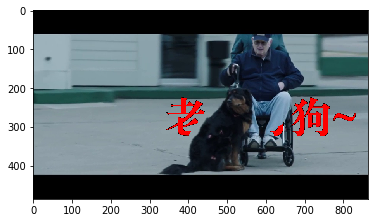

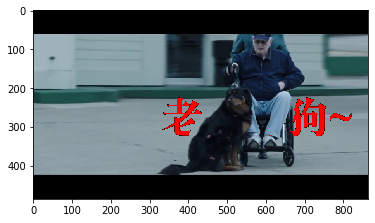

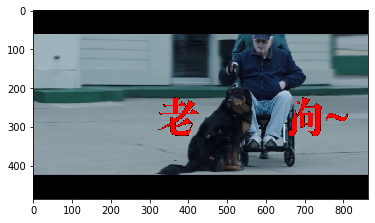

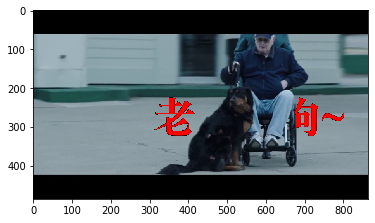

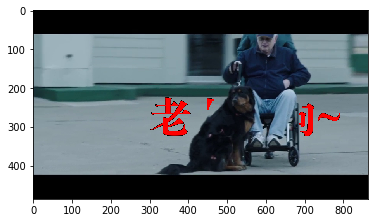

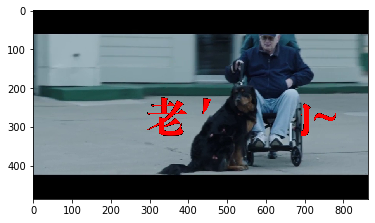

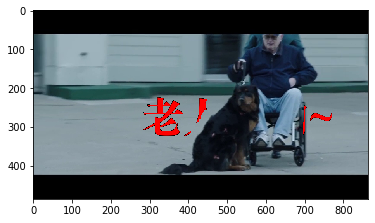

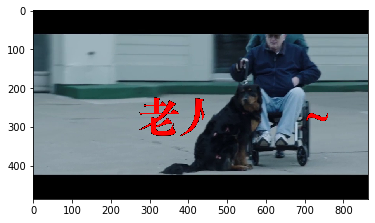

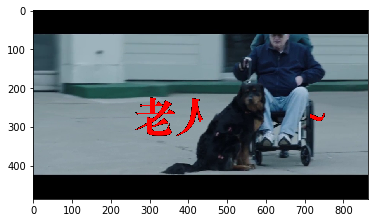

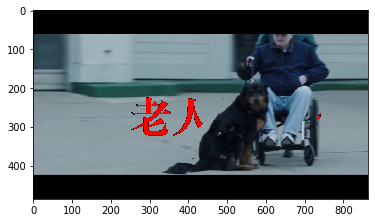

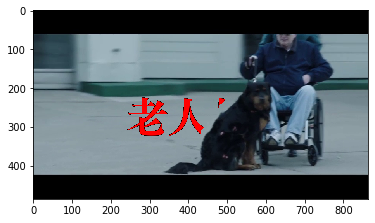

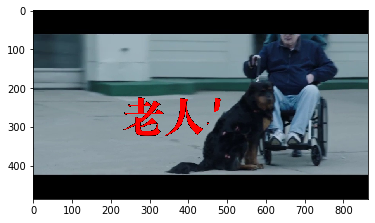

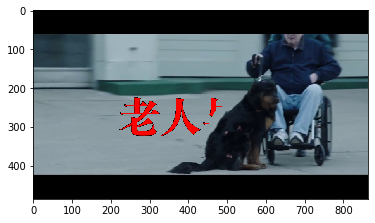

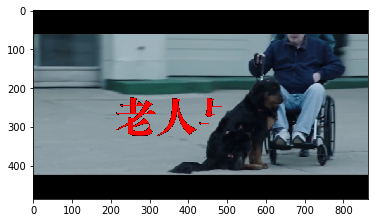

In [160]:
gif_frames=[]
move=0
for img in main_scenes_frames[0]:
    #print(img)
    res=design(img,"老人与狗~",200+move,200)
    plt.imshow(cv2.cvtColor(res,cv2.COLOR_BGR2RGB))
    plt.show()
    gif_frames.append(res)
    if len(gif_frames)>15:
        move-=10
    else:
        move+=10

In [149]:
#保存成gif
def images_to_gif(imgs=[],output_file_path="",duration=120):
    imgs=[Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)) for img in imgs]
    img=imgs[0]
    img.save(fp=output_file_path, format='GIF', append_images=imgs,save_all=True, duration=duration, loop=0)
    return

In [161]:
images_to_gif(gif_frames,"video/test2.gif",100)

# 思考：透明度、高斯模糊

In [85]:
# 透明度

img = gif_frames[0]
b,g,r= cv2.split(img)

alpha_channel = np.ones(b.shape, dtype=b.dtype) * 255

# 最小值为0
alpha_channel[:, :int(b.shape[0] / 2)] = 100

img_BGRA = cv2.merge((b, g, r, alpha_channel))

cv2.imwrite("test.png", img_BGRA)

#cv2.imwrite("result.jpg", img)

True

In [136]:
# 透明底的文字+高斯模糊
text_image=draw_text("透明底的文字",120)
b,g,r= cv2.split(text_image)

alpha_channel = np.ones(b.shape, dtype=b.dtype) * 255
print(alpha_channel.shape)
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        alpha_channel[i][j]=r[i][j]
        #print(r[i][j],g[i][j],b[i][j],alpha_channel[i][j])
text_image = cv2.merge((b, g, r, alpha_channel))

text_image = cv2.GaussianBlur(text_image,(3,3),0)

cv2.imwrite("test.png", text_image)

(142, 720)


True

In [137]:
#往图片上绘制透明底的文字
image = cv2.imread('img/Maryam-Razavi_pitsitoppi590.jpg') 
image= cv2.cvtColor(image,cv2.COLOR_BGR2BGRA)
text_image=cv2.resize(text_image,(200,55))

image[0:text_image.shape[0],0:text_image.shape[1]]=cv2.add(image[0:text_image.shape[0],0:text_image.shape[1]],text_image)

# image[0:text_image.shape[0],0:text_image.shape[1]]=cv2.addWeighted(image[0:text_image.shape[0],0:text_image.shape[1]],
#                                                                    0.7,
#                                                                    text_image,0.3,0)

cv2.imwrite("test.png", image)

True